<a href="https://colab.research.google.com/github/dsikar/notebooks/blob/main/RGBMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting RBG means for track one

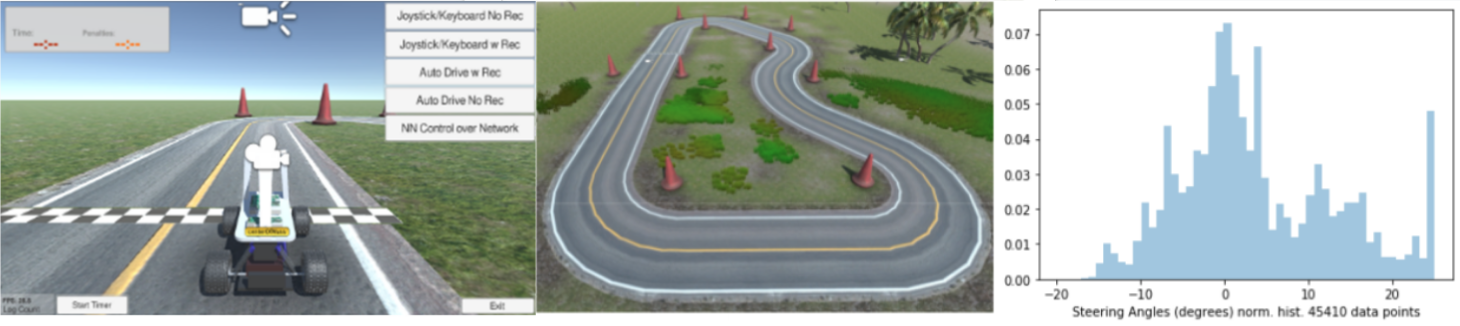

Our dataset consists of 1394 images acquired at a rate of approximately 21 frames-per-second, while the self-driving simulated car drives around the generated track, taking approximately one minute to complete the lap.

We are interested in computing the RGB mean (overall and per channel) of the image presented to the AV neural network

In [ ]:
# Clone repository
!git clone https://github.com/dsikar/sdsandbox
%cd  sdsandbox/src/
!tar xvf examples/logs_Wed_Nov_25_23_39_22_2020.tar.gz
# delete bad image
! rm logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg
# total images
# !pwd # /content/sdsandbox/src
# !ls logs_Wed_Nov_25_23_39_22_2020/*.jpg | wc -l # 1394

In [3]:
# Utility library
def GetJSONSteeringAngles(filemask):
    """
    Get steering angles stored as 'user/angle' attributes in .json files
    Inputs:
        filemask: string, path and mask
    Outputs
        svals: list, steering values
    """
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    # matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)
    # steering values
    svals = []
    for fullpath in matches:
      # print(fullpath)
      frame_number = os.path.basename(fullpath).split("_")[0]
      json_filename = os.path.join(os.path.dirname(fullpath), "record_" + frame_number + ".json")
      jobj = load_json(json_filename)
      svals.append(jobj['user/angle'])
    return svals

def load_json(filepath):
    """
    Load a json file
    Inputs
        filepath: string, path to file
    Outputs
        data: dictionary, json key, value pairs
    Example
    path = "~/git/msc-data/unity/roboRacingLeague/log/logs_Sat_Nov_14_12_36_16_2020/record_11640.json"
    js = load_json(path)
    """
    with open(filepath, "rt") as fp:
        data = json.load(fp)
    return data 

def sort_sdsandbox_files(matches):
  """
  Sort sdsandbox files in format e.g. 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
  This is to emulate a sort-by-date feature, once files have been copied and datetime stamp is lost

  Parameters
  -------
  matches: list of strings, image filepaths

  Output
  -------
  sorted_matches: list of strings, sorted list

  Example
  -------
  matches = sort_sdsandbox_files(matches)
  for match in matches:
    print(match)
  """
  filenums = {}
  sorted_matches = []
  for match in matches:
    # match ~ 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
    # match.split('/')[-1].split('_')[0] ~ 1339
    filenums[int(match.split('/')[-1].split('_')[0])] = match

  filenums = sorted(filenums.items(), key=lambda filenums: filenums[0])
  for key in filenums:
    sorted_matches.append(key[1]) 

  return sorted_matches        

def GetPredictions(filemask, modelpath, datashift = 0, modelname = 'nvidia2'):
    """
    Get predictions of a given model
    
    Parameters
    -------
        filemask: string, path of the images to generate steering angle predictions
        modelpath: string, path of the trained model 
        datashift: integer, RGB intensity mean shift to left (negative) or right (positive) or 
        input image RGB intensity mean
        modelname: string, model name refering to input geometry to use
    
    Output
    -------
        predictions: numpy array of floats, steering angle predictons
        
    Example:
    filemask = '../../../../Downloads/dataset/unity/genTrack/genTrackOneLap/logs_Wed_Nov_25_23_39_22_2020/*.jpg'
    modelpath = '../../../../Downloads/trained_models/nvidia2/20201207192948_nvidia2.h5'
    datashift = -10
    filename = 'nvidia2'
    
    p = GetPredictions(filemask, modelpath, datashift)
    
    """
    import os
    from tensorflow.python.keras.models import load_model
    import cv2
    import Augment_cls    
    import fnmatch
    from PIL import Image
    import numpy as np
    import sys # for exception handling

    ag = Augment_cls.Augment_cls(modelname)

    model = load_model(modelpath)
    model.compile("sgd", "mse")
    
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)

    # steering values
    svals = []
    for fullpath in matches: 
      try:
        image = Image.open(fullpath)
        #PIL Image as a numpy array
        image = np.array(image, dtype=np.float32)
        # shift distribution
        image, rgbmean, rgbstd, rgbvar = shiftRGBValues(image, datashift, datashift, datashift)   
        # keep data type for prediction model
        image = np.array(image, dtype=np.float32)   
        image = ag.preprocess(image)
        image = image.reshape((1,) + image.shape)

        mod_pred = model.predict(image)   
        svals.append(mod_pred)

      except:
        print("Error ", sys.exc_info()[0], " occurred processing image ", fullpath, ", skipping") 
        pass

    preds = []
    # only return steering angles
    for i in range(0, len(svals)):
      preds.append(svals[i][0][0])      
    return preds  


# change rgb values
# https://stackoverflow.com/questions/59320564/how-to-access-and-change-color-channels-using-pil
def shiftRGBValues(img, rv=0, gv=0, bv=0):
  """
  Shift RGB values using PIL, and return mean and standard deviations

  Parameters
  -------
    img: uint8 numpy image array
    rv: integer, value to be added to red channel
    gv: integer, value to be added to green channel
    bv, integer, value to be added to blue channel

  Output
  -------
    myimg: uint8 numpy image array
    rgbmean: float, rgb mean
    rgbstd: float, rgb standard deviation
    rgbvar: float, rgb variance

  Example
  -------
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  img = mpimg.imread('steph.jpeg')
  myimg, rgbmean, rgbstd, rgbvar = changeRGB(img, 60, 0, 0)
  plt.imshow(myimg)
  """
  from PIL import Image
  import numpy as np

  im = Image.fromarray(np.uint8(img))

  # Split into 3 channels
  r, g, b = im.split()

  # Red
  r = r.point(lambda i: i + rv)

  # Green
  g = g.point(lambda i: i + gv)

  # Blue
  b = b.point(lambda i: i + bv)

  # Recombine back to RGB image
  result = Image.merge('RGB', (r, g, b))

  rgbmean = np.mean(result) 
  rgbstd = np.std(result) 
  rgbvar = np.var(result) 
  # Convert to uint8 numpy array
  myimg = np.asarray(result)

  return myimg, rgbmean, rgbstd, rgbvar    


# Find and order images



In [4]:
import os
from tensorflow.python.keras.models import load_model
import cv2
import Augment_cls    
import fnmatch
from PIL import Image
import numpy as np
import sys # for exception handling

modelname = 'nvidia2'
filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'

ag = Augment_cls.Augment_cls(modelname)
filemask = os.path.expanduser(filemask)
path, mask = os.path.split(filemask)

matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, mask):
        matches.append(os.path.join(root, filename))
# sort by create date
matches = sorted(matches, key=os.path.getmtime)
# sort by filename prefix
matches = sort_sdsandbox_files(matches)


In [5]:
myimgpath = "logs_Wed_Nov_25_23_39_22_2020/1132_cam-image_array_.jpg"
from utils.utils import get_rgb_avgs

# help(get_rgb_avgs)
# 1 open image
img = Image.open(myimgpath)
rgb_avg, r_avg, g_avg, b_avg = get_rgb_avgs(img)
print("RGB avg: {:.2f}, Red avg: {:.2f}, Green avg: {:.2f}, Blue avg: {:.2f}".format(rgb_avg, r_avg, g_avg, b_avg))

RGB avg: 146.44, Red avg: 132.99, Green avg: 147.80, Blue avg: 158.53


# Make videos logs_Wed_Nov_25_23_39_22_2020

In [33]:
import cv2
import os

image_folder = 'logs_Wed_Nov_25_23_39_22_2020'
video_name = 'logs_Wed_Nov_25_23_39_22_2020.avi'

images = matches # sorted, instead of [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
# frame = cv2.imread(os.path.join(image_folder, images[0]))
frame = cv2.imread(images[0])
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 24, (width,height))

for image in images:
    # video.write(cv2.imread(os.path.join(image_folder, image)))
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()

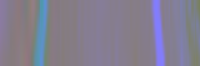

In [34]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(images[0])
img = ag.preprocess(img)
cv2_imshow(img)

# Make YUV video

In [36]:
import cv2
import os

video_name = 'logs_Wed_Nov_25_23_39_22_2020_yuv.avi'

images = matches # sorted, instead of [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
# frame = cv2.imread(os.path.join(image_folder, images[0]))
frame = cv2.imread(images[0])
frame = ag.preprocess(frame)
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 24, (width,height))

for image in images:
    # video.write(cv2.imread(os.path.join(image_folder, image)))
    image = cv2.imread(image)
    image = ag.preprocess(image)
    video.write(image)

cv2.destroyAllWindows()
video.release()

# RGB and YUV pixel intensity plots

In [7]:
from PIL import Image
import numpy as np
i = 1
avgs = []
images = matches
for image in images:
  img = Image.open(image)
  img = np.array(img)
  # rgb
  rgb_avg, r_avg, g_avg, b_avg = get_rgb_avgs(img)  
  # yuv
  img = cv2.imread(image)
  img = ag.preprocess(img)
  yuv_avg, yuv_r_avg, yuv_g_avg, yuv_b_avg = get_rgb_avgs(img) 
  avgs.append([i,rgb_avg, r_avg, g_avg, b_avg,yuv_avg, yuv_r_avg, yuv_g_avg, yuv_b_avg])
  i = i + 1    

# RGB

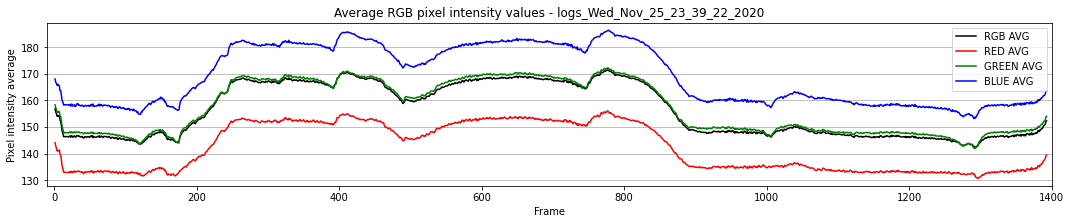

In [110]:
import matplotlib.pyplot as plt
# indexes
IDX = 0
RGB_AVG = 1
R_AVG = 2
G_AVG = 3
B_AVG = 4
YUV_AVG = 5
YUV_R_AVG = 6
YUV_G_AVG = 7
YUV_B_AVG = 8

# type cast
avgs = np.array(avgs)

# set dimensions
plt.rcParams["figure.figsize"] = (18,3)
# plot
plt.plot(avgs[:,IDX], avgs[:,RGB_AVG], label='RGB AVG', color="black")
plt.plot(avgs[:,IDX], avgs[:,R_AVG], label='RED AVG', color="red")
plt.plot(avgs[:,IDX], avgs[:,G_AVG], label='GREEN AVG', color="green")
plt.plot(avgs[:,IDX], avgs[:,B_AVG], label='BLUE AVG', color="blue")

plt.ylabel('Pixel intensity average')
plt.xlabel('Frame')    
# Set a title of the current axes.

mytitle = 'Average RGB pixel intensity values - logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')


# plt.xlim([-5,len(g)+5])

# set limit
xmin = -10
xmax = 1400
plt.xlim([xmin,xmax])
#plt.gca().invert_yaxis()
plt.legend(loc='upper right')
plt.show()

# YUV

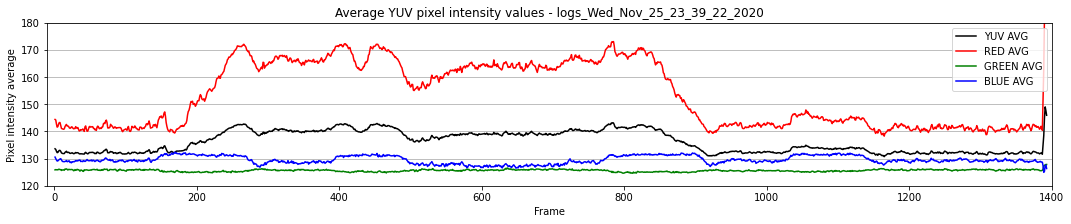

In [111]:
# plot
plt.plot(avgs[:,IDX], avgs[:,YUV_AVG], label='YUV AVG', color="black")
plt.plot(avgs[:,IDX], avgs[:,YUV_R_AVG], label='RED AVG', color="red")
plt.plot(avgs[:,IDX], avgs[:,YUV_G_AVG], label='GREEN AVG', color="green")
plt.plot(avgs[:,IDX], avgs[:,YUV_B_AVG], label='BLUE AVG', color="blue")

plt.ylabel('Pixel intensity average')
plt.xlabel('Frame')    
# Set a title of the current axes.

mytitle = 'Average YUV pixel intensity values - logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')


# plt.xlim([-5,len(g)+5])

# set limits
xmin = -10
xmax = 1400
plt.xlim([xmin,xmax])
ymin = 120
ymax = 180
plt.ylim([ymin,ymax])
#plt.gca().invert_yaxis()
plt.legend(loc='upper right')
plt.show()

# RGB and YUV averages

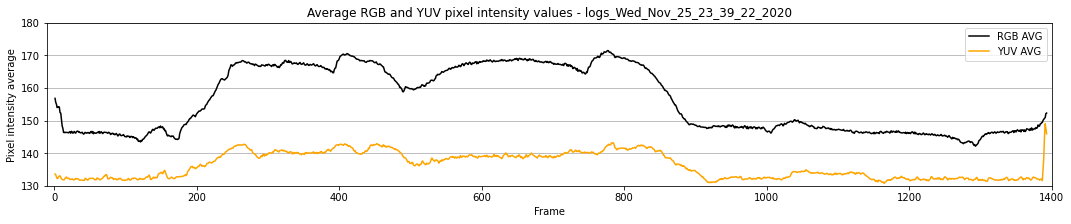

In [112]:
# plot
plt.plot(avgs[:,IDX], avgs[:,RGB_AVG], label='RGB AVG', color="black")
plt.plot(avgs[:,IDX], avgs[:,YUV_AVG], label='YUV AVG', color="orange")

plt.ylabel('Pixel intensity average')
plt.xlabel('Frame')    
# Set a title of the current axes.

mytitle = 'Average RGB and YUV pixel intensity values - logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')


# plt.xlim([-5,len(g)+5])

# set limits
xmin = -10
xmax = 1400
plt.xlim([xmin,xmax])
ymin = 130
ymax = 180
plt.ylim([ymin,ymax])
#plt.gca().invert_yaxis()
plt.legend(loc='upper right')
plt.show()

# Histogram distance
We first plot an image and related histogram

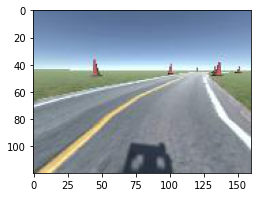

In [11]:
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
plt.imshow(img)

def rgb_img_hists(img):
  """"
  Return RGB image red, green and blue channel histograms
  Inputs
    img: image array
  Outputs
    count_r: array, red channel intensity value bins
    count_g: array, green channel intensity value bins
    count_b: array, blue channel intensity value bins
  Example
    imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
    img = Image.open(imgpath)
    count_r, count_g, count_b = rgb_img_hists(img)  
  """
  # number of distinct values in one byte
  nb_bins = 256
  count_r = np.zeros(nb_bins)
  count_g = np.zeros(nb_bins)
  count_b = np.zeros(nb_bins)

  # Calculate manual hist
  x = np.array(img)
  x = x.transpose(2, 0, 1)
  hist_r = np.histogram(x[0], bins=nb_bins, range=[0, 255])
  hist_g = np.histogram(x[1], bins=nb_bins, range=[0, 255])
  hist_b = np.histogram(x[2], bins=nb_bins, range=[0, 255])
  count_r = hist_r[0]
  count_g = hist_g[0]
  count_b = hist_b[0]
  return count_r, count_g, count_b

imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
plt.imshow(img) 
count_r, count_g, count_b = rgb_img_hists(img) 

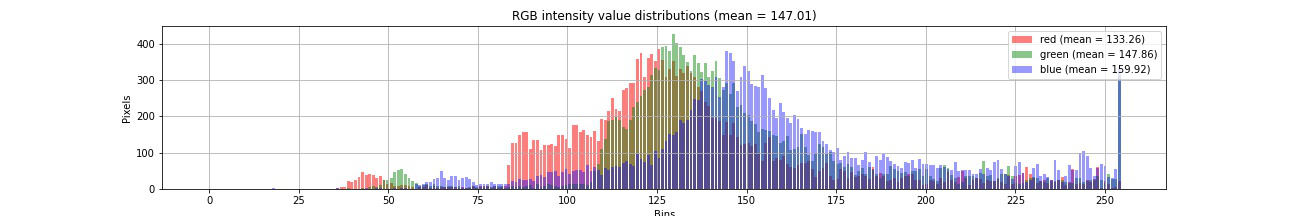

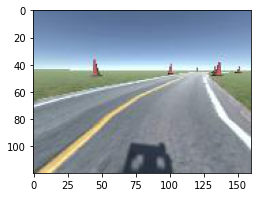

In [12]:
from utils.utils import plot_img_hist # need utils.py
from PIL import Image
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
image = Image.open(imgpath)
plt.imshow(image)
myfig = plot_img_hist(image)
myplot = mpimg.imread('temp_plot.jpg')
# correct channels
b,g,r = cv2.split(myplot)
myplot = cv2.merge([r,g,b])
cv2_imshow(myplot)

In [96]:
# visually OK, green value at 130 is over 400
hist_g[0][130] # 428 OK
count_g[130] # 428 OK
len(count_g) # 256 OK
type(count_g) # numpy.ndarray

numpy.ndarray

# Positive 50 pixel shift


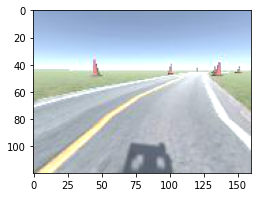

In [65]:
datashift = 50
imageshifted, rgbmean, rgbstd, rgbvar = shiftRGBValues(img, datashift, datashift, datashift)
plt.imshow(imageshifted)

In [114]:
# count_r, count_g, count_b = rgb_img_hists(img) 
# shift_count_r, shift_count_g, shift_count_b = rgb_img_hists(imageshifted) 
dist_r = 0
dist_g = 0
dist_b = 0
for i in range(0, len(count_r)):
  dist_r += abs(count_r[i] - shift_count_r[i])
  dist_g += abs(count_g[i] - shift_count_g[i])
  dist_b += abs(count_b[i] - shift_count_b[i])
# wrong!!! assumption, it is the minimum we want. We are binning intensity values for every pixel, the number of intensity
# values for each channel will always be the height multiplied by the width of the image, in this example 120 * 160 = 19200
# If a pixel changes from image A to image B, and we compare the histograms, we are comparing bin counts, that is, the count
# in each bin. The minimum value will be the overlap area. It does not make sense to compare the absolute value of the difference
# as that could lead to counts greater than 19200 for the 256 bins, which would not make sense.
# Hence, we take the minimum value and subtract from 19200, we can take the normalised value and treat the result of the 
# division of the minimum by 19200, as the overlap percentage for 1 channel, and the the average of the corresponding value
# for each channel, or the sum and the same division by the total number of bins for all channels i.e. 57600
# as the overlap percentage
print("Histogram non overlap with +50 shift - r: {}, g: {}, b: {}".format(dist_r,dist_g, dist_b))

Histogram non overlap with +50 shift - r: 24816, g: 26878, b: 22618


# RGB image histogram intersection

We define the histogram intersection $ H_{irgb} $ of RGB images $P, Q$ as

$
H_{irgb}(P, Q) = \frac{1}{t_p} \sum\limits_{x\in\mathcal{X}}argmin(P(x), Q(x)) 
$

If $P,Q$ are the same for every $ x $, then the summation will be equal to $ t_p$ and resulting in 1 for a complete overlap. If $argmin(P(x), Q(x))$ is equal to zero for every $x$, then the summation will be equal to zero meaning there is no overlap between the histograms.

In [98]:
def histogram_intersection(img, shift):
  """
  Compute the histogram_intersection between two distributions
  Inputs
    img: RGB image array
    shift: integer, amount of shift to apply to image
  Outputs
    overlap: percentage, overlapping area, 1 is complete overlap, 0 is no overlap
  Example
    from PIL import Image
    imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
    img = Image.open(imgpath)
    print(histogram_intersection(img, 10))
  """
  import numpy as np
  # apply shift
  img_shift, rgbmean, rgbstd, rgbvar = shiftRGBValues(img, shift, shift, shift)
  # get histograms
  count_r, count_g, count_b = rgb_img_hists(img) 
  shift_count_r, shift_count_g, shift_count_b = rgb_img_hists(img_shift) 
  # compute distance 
  dist_r = 0
  dist_g = 0
  dist_b = 0 
  # get the lower of the bin count for every bin
  for i in range(0, len(count_r)):
    dist_r += min(count_r[i], shift_count_r[i])
    dist_g += min(count_g[i], shift_count_g[i])
    dist_b += min(count_b[i], shift_count_b[i])
  # total overlap area will be <= total number of pixels for all channels
  overlap = dist_r + dist_g + dist_b
  # normalise by total number of pixels in all channels
  img = np.array(img)
  imgdims = img.shape
  k = 1
  for i in range(len(imgdims)):
    k = k * imgdims[i] 
  # if overlap is equal to the total amount of pixels, the distributions are the same,
  # otherwise there are buckets i.e. Q(x_i) of one distribution that do not overlap the other.
  # if overlap is 0, the ratio will also be 0, that is 0 % of the distributions overlap
  return overlap / k

# Relative entropy
We use the term $t_p = \prod\limits_{n=1}^{N}I_n $

to normalise our bin counts $ P(x), Q(x) $ where $ N $ is the number of dimensions in the image array $ I $ and $ I_n $ is the number of elements in each image dimension $n$.

We add a small positive term $ \epsilon $ to $ P(x), Q(x) $ to avoid division by zero and taking the logarithm base 10 of zero which is undefined.

Our relative entropy for RGB image shifts can then be expressed as 

$
D_\text{KLrgb}(P \parallel Q) = \sum\limits_{x\in\mathcal{X}} P(x)t_p^{-1}\log\left(\frac{(P(x)+\epsilon) t_p^{-1}}{(Q(x)+\epsilon)t_p^{-1}}\right).
$

which simplifies to:

$
D_\text{KLrgb}(P \parallel Q) = \sum\limits_{x\in\mathcal{X}} P(x)t_p^{-1} \log\left(\frac{P(x)+\epsilon}{Q(x)+\epsilon}\right).
$

where $P, Q$ are on the same domain $\mathcal{X}$.


In [90]:
def relative_entropy(img, shift):
  """
  Compute the relative entropy between two distributions
  Inputs
    img: RGB image array
    shift: integer, amount of shift to apply to image
  Outputs
    bd: float, relative entropy
  Example
    from PIL import Image
    imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
    img = Image.open(imgpath)
    print(relative_entropy(img, 10))
  """ 
  import numpy as np
  # find normalising factor t_p (total pixels)
  img = np.array(img)
  imgdims = img.shape
  k = 1
  for i in range(len(imgdims)):
    k = k * imgdims[i]  
  # apply shift
  img_shift, rgbmean, rgbstd, rgbvar = shiftRGBValues(img, shift, shift, shift)
  # get histograms
  count_r, count_g, count_b = rgb_img_hists(img) 
  shift_count_r, shift_count_g, shift_count_b = rgb_img_hists(img_shift)  
  # added term to avoid division by 0
  epsilon = 1  
  # compute relative entropy
  re = 0 
  for i in range(0, len(count_r)):
    shift_r = epsilon if shift_count_r[i] == 0 else shift_count_r[i]
    shift_g = epsilon if shift_count_g[i] == 0 else shift_count_g[i]
    shift_b = epsilon if shift_count_b[i] == 0 else shift_count_b[i]
    cnt_r = epsilon if count_r[i] == 0 else count_r[i]
    cnt_g = epsilon if count_g[i] == 0 else count_g[i]
    cnt_b = epsilon if count_b[i] == 0 else count_b[i]    
    re = re + count_r[i] / k * np.log10(cnt_r / shift_r)
    re = re + count_g[i] / k * np.log10(cnt_g / shift_g)
    re = re + count_b[i] / k * np.log10(cnt_b / shift_b)
  return re 

from PIL import Image
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
print(relative_entropy(img, 100))

1.5490732076115763


# Plot relative entropy 

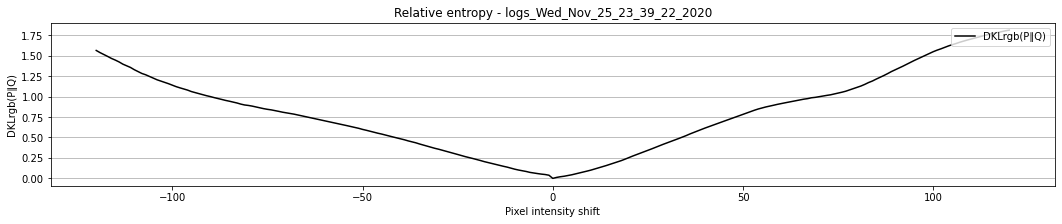

In [113]:
from PIL import Image
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
relents = []
for i in range(-120, 121):
  relent = relative_entropy(img, i)
  relents.append([i, relent])

relents = np.array(relents)
import matplotlib.pyplot as plt
plt.plot(relents[:,0], relents[:,1], label='DKLrgb(P∥Q)', color="black")

plt.ylabel('DKLrgb(P∥Q)')
plt.xlabel('Pixel intensity shift') 

mytitle = 'Relative entropy - logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')

plt.legend(loc='upper right')
plt.show()

# Bhattacharyya RGB distance

$ D_Brgb(P,Q) = -ln ( BCrgb(P,Q)  $

where

$ BCrgb(P,Q) = \sum\limits_{x\in \mathcal{X}} \sqrt{P(x) Q(x)} $

Since our $ P(x), Q(x) $ is the bin count divided by the total amount of pixels $t_p$ in the image, in our example $ t_p = 120 × 160 × 3 = 57600 $

where $t_p = \prod\limits_{n=1}^{I_d}I_n $

Our expression becomes:

$ BCrgb(P,Q) = \sum\limits_{x\in \mathcal{X}} \sqrt{\frac{P(x)}{t_p} \frac{Q(x)}{t_p}} $ 

$ BCrgb(P,Q) = \sum\limits_{x\in \mathcal{X}} \sqrt{\frac{P(x)Q(x)}{t_p^2} } $ 

$ BCrgb(P,Q) = \sum\limits_{x\in \mathcal{X}} \frac{\sqrt{P(x)Q(x)}}{t_p}  $ 

$ BCrgb(P,Q) = \sum\limits_{x\in \mathcal{X}} \sqrt{P(x)Q(x)} \times t_p^{-1} $ 



In [70]:
def Bhattacharyya_rgb_distance(img, shift):
  """
  Compute the Bhattacharyya RGB distance between two distributions
  Inputs
    img: RGB image array
    shift: integer, amount of shift to apply to image
  Outputs
    bd: float, Bhattacharyya distance
  Example
    from PIL import Image
    imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
    img = Image.open(imgpath)
    print(Bhattacharyya_rgb_distance(img, 10))
  """ 
  import numpy as np
  from math import sqrt
  # find normalising factor t_p (total pixels)
  img = np.array(img)
  imgdims = img.shape
  k = 1
  for i in range(len(imgdims)):
    k = k * imgdims[i]  
  # apply shift
  img_shift, rgbmean, rgbstd, rgbvar = shiftRGBValues(img, shift, shift, shift)
  # get histograms
  count_r, count_g, count_b = rgb_img_hists(img) 
  shift_count_r, shift_count_g, shift_count_b = rgb_img_hists(img_shift)  
  # compute Bhattacharyya coefficient
  bc = 0 
  for i in range(0, len(count_r)):
    bc = bc + sqrt(count_r[i] * shift_count_r[i]) / k
    bc = bc + sqrt(count_g[i] * shift_count_g[i]) / k
    bc = bc + sqrt(count_b[i] * shift_count_b[i]) / k
    #dist_r += min(count_r[i], shift_count_r[i])
    #dist_g += min(count_g[i], shift_count_g[i])
    #dist_b += min(count_b[i], shift_count_b[i]) 
  bd = -np.log(bc)
  return bd  

# Plot RGB histogram intersection $ H_{irgb}$ percentages for shifts between -120 and 120 pixels


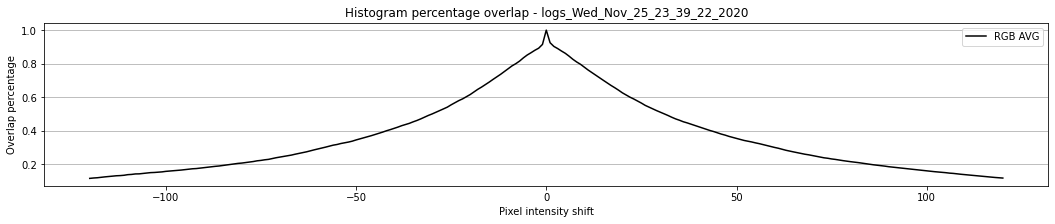

In [114]:
# print(hist_overlap(img, 0)) # = 1.0
from PIL import Image
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
overlaps = []
for i in range(-120, 121):
  overlap = histogram_intersection(img, i)
  overlaps.append([i, overlap])

overlaps = np.array(overlaps)
import matplotlib.pyplot as plt
plt.plot(overlaps[:,0], overlaps[:,1], label='RGB AVG', color="black")

plt.ylabel('Overlap percentage')
plt.xlabel('Pixel intensity shift') 

mytitle = 'Histogram percentage overlap - logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')

plt.legend(loc='upper right')
plt.show()

# Plot Bhattacharyya RGB distance

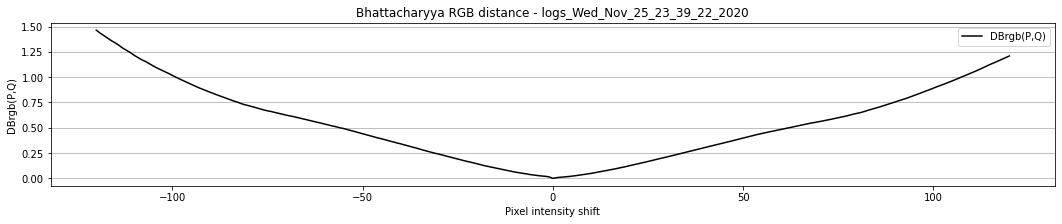

In [115]:
from PIL import Image
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
brgbds = []
for i in range(-120, 121):
  brgbd = Bhattacharyya_rgb_distance(img, i)
  brgbds.append([i, brgbd])

brgbds = np.array(brgbds)
import matplotlib.pyplot as plt
plt.plot(brgbds[:,0], brgbds[:,1], label='DBrgb(P,Q)', color="black")

plt.ylabel('DBrgb(P,Q)')
plt.xlabel('Pixel intensity shift') 

mytitle = 'Bhattacharyya RGB distance - logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')

plt.legend(loc='upper right')
plt.show()

# Statistical distance utility functions

In [122]:
def plot_Bhattacharyya_rgb_distance(img):
  """"
  Plot Bhattacharyya rgb distance for image array img and return y and x axis
  Inputs
    img: array, image
  Outputs
    brgbds_x: array of integers, x axis values
    brgbds_y: array of floats, y axis values
  Example
    from PIL import Image
    imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
    img = Image.open(imgpath)
    bdx, bdy = plot_Bhattacharyya_rgb_distance(img)
  """
  brgbds = []
  for i in range(-120, 121):
    brgbd = Bhattacharyya_rgb_distance(img, i)
    brgbds.append([i, brgbd])

  brgbds = np.array(brgbds)
  import matplotlib.pyplot as plt
  plt.plot(brgbds[:,0], brgbds[:,1], label='DBrgb(P,Q)', color="black")

  plt.ylabel('DBrgb(P,Q)')
  plt.xlabel('Pixel intensity shift') 

  mytitle = 'Bhattacharyya RGB distance'
  plt.title(mytitle)
  plt.grid(axis='y')

  plt.legend(loc='upper right')
  plt.show()
  return brgbds[:,0], brgbds[:,1]

def plot_relative_entropy(img):
  """"
  Plot relative entropy for image array img and return y and x axis
  Inputs
    img: array, image
  Outputs
    relents_x: array of integers, x axis values
    relents_y: array of floats, y axis values
  Example
    from PIL import Image
    imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
    img = Image.open(imgpath)
    rex, rey = plot_relative_entropy(img)
  """
  relents = []
  for i in range(-120, 121):
    relent = relative_entropy(img, i)
    relents.append([i, relent])

  relents = np.array(relents)
  import matplotlib.pyplot as plt
  plt.plot(relents[:,0], relents[:,1], label='DKLrgb(P∥Q)', color="black")

  plt.ylabel('DKLrgb(P∥Q)')
  plt.xlabel('Pixel intensity shift') 

  mytitle = 'Relative entropy'
  plt.title(mytitle)
  plt.grid(axis='y')

  plt.legend(loc='upper right')
  plt.show()
  return relents[:,0], relents[:,1]  

def plot_histogram_intersection(img):
  """"
  Plot histogram intersection for image array img and return y and x axis
  Inputs
    img: array, image
  Outputs
    hix: array of integers, x axis values
    hiy: array of floats, y axis values
  Example
    from PIL import Image
    imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
    img = Image.open(imgpath)
    hix, hiy = plot_histogram_intersection(img)
  """
  overlaps = []
  for i in range(-120, 121):
    overlap = histogram_intersection(img, i)
    overlaps.append([i, overlap])

  overlaps = np.array(overlaps)
  import matplotlib.pyplot as plt
  plt.plot(overlaps[:,0], overlaps[:,1], label='Histogram intersection percentage', color="black")

  plt.ylabel('Overlap percentage')
  plt.xlabel('Pixel intensity shift') 

  mytitle = 'Histogram intersection percentage'
  plt.title(mytitle)
  plt.grid(axis='y')

  plt.legend(loc='upper right')
  plt.show()
  return overlaps[:,0], overlaps[:,1]

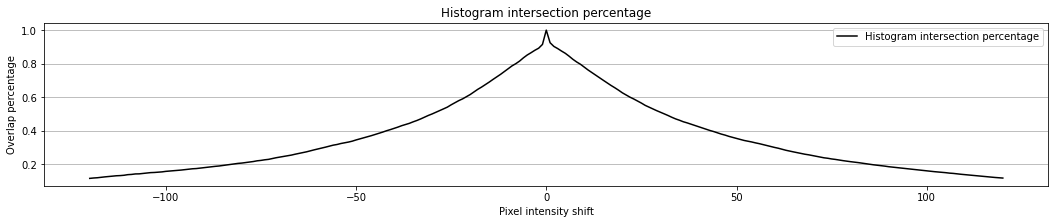

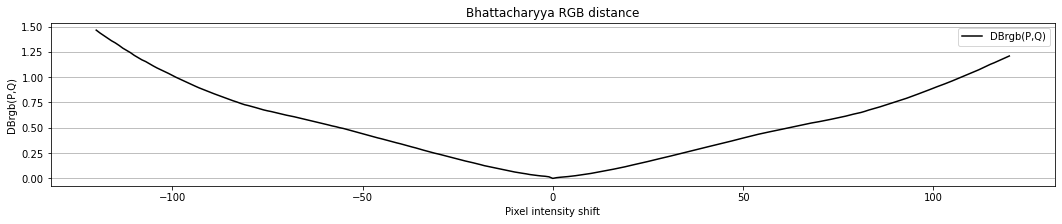

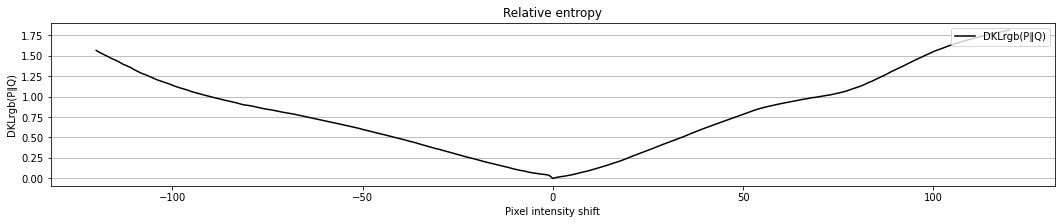

In [123]:
from PIL import Image
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)

hix, hiy = plot_histogram_intersection(img)
bdx, bdy = plot_Bhattacharyya_rgb_distance(img)
rex, rey = plot_relative_entropy(img)

# Plot histogram, relative entropy and Bhattacharyya distance RGB image

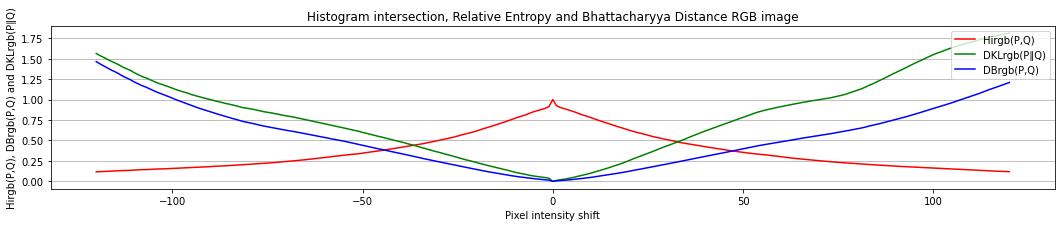

In [125]:
plt.ylabel('Hirgb(P,Q), DBrgb(P,Q) and DKLrgb(P∥Q)')
plt.xlabel('Pixel intensity shift') 

plt.plot(hix, hiy, label='Hirgb(P,Q)', color="red")
plt.plot(rex, rey, label='DKLrgb(P∥Q)', color="green")
plt.plot(bdx, bdy, label='DBrgb(P,Q)', color="blue")

mytitle = 'Histogram intersection, Relative Entropy and Bhattacharyya Distance RGB image'
plt.title(mytitle)
plt.grid(axis='y')

plt.legend(loc='upper right')
plt.show()



# Plot histogram, relative entropy and Bhattacharyya distance YUV image

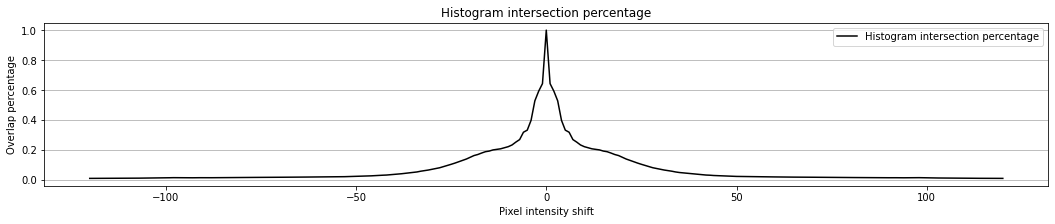

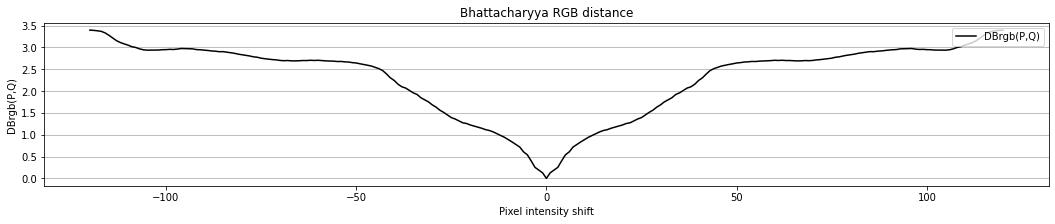

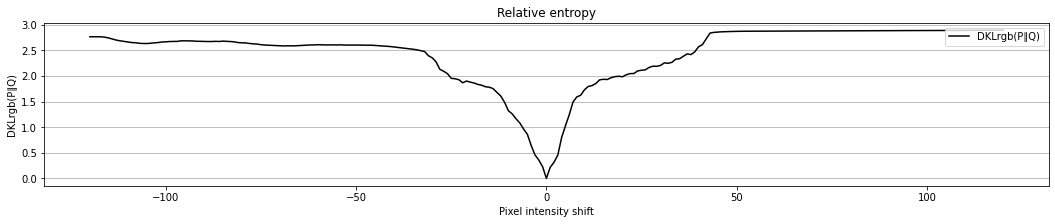

In [126]:
from PIL import Image
import Augment_cls  
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
modelname = 'nvidia2'

ag = Augment_cls.Augment_cls(modelname)
img = np.array(img)
img = ag.preprocess(img)
yuv_img = img

hix, hiy = plot_histogram_intersection(yuv_img)
bdx, bdy = plot_Bhattacharyya_rgb_distance(yuv_img)
rex, rey = plot_relative_entropy(yuv_img)

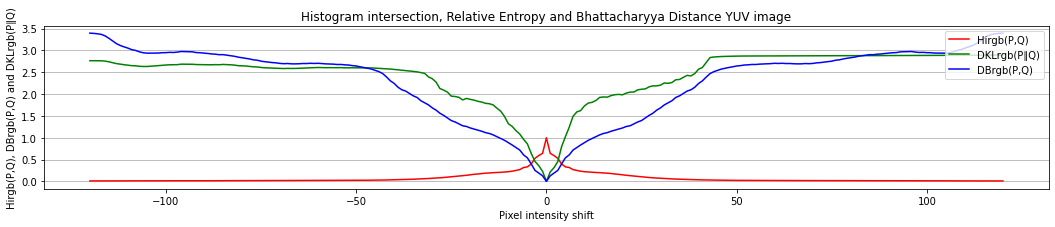

In [127]:
plt.ylabel('Hirgb(P,Q), DBrgb(P,Q) and DKLrgb(P∥Q)')
plt.xlabel('Pixel intensity shift') 

plt.plot(hix, hiy, label='Hirgb(P,Q)', color="red")
plt.plot(rex, rey, label='DKLrgb(P∥Q)', color="green")
plt.plot(bdx, bdy, label='DBrgb(P,Q)', color="blue")

mytitle = 'Histogram intersection, Relative Entropy and Bhattacharyya Distance YUV image'
plt.title(mytitle)
plt.grid(axis='y')

plt.legend(loc='upper right')
plt.show()

# Plot RGB and YUV for report


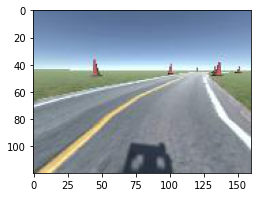

In [128]:
from PIL import Image
import Augment_cls  
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
img = Image.open(imgpath)
plt.imshow(img)

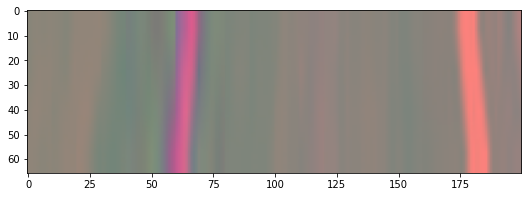

In [129]:
modelname = 'nvidia2'
ag = Augment_cls.Augment_cls(modelname)
img = np.array(img)
img = ag.preprocess(img)
yuv_img = img
plt.imshow(yuv_img)

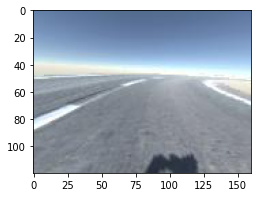

In [131]:
# generated road
imgpath = 'examples/48140_cam-image_array_.jpg'
img = Image.open(imgpath)
plt.imshow(img)

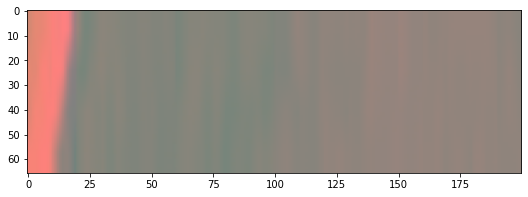

In [132]:
img = np.array(img)
img = ag.preprocess(img)
yuv_img = img
plt.imshow(yuv_img)